## Hotel Recommendation Model

All online travel agencies are scrambling to meet the Artificial Intelligence driven personalization standard set by Amazon and Netflix. In addition, the world of online travel has become a highly competitive space where brands try to capture our attention (and wallet) with recommending, comparing, matching, and sharing. For this assignment, we aim to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details. 

### Data

Data for this assignment has been collected from the following Kaggle competition:
https://www.kaggle.com/c/expedia-hotel-recommendations/data

### File descriptions

**train.csv** - the training set

**test.csv** - the test set

**destinations.csv** - hotel search latent attributes

**sample_submission.csv** - a sample submission file in the correct format

### Approach

The given problem is interpreted as a 100 class classification problem, where the classes are the hotel clusters.

In [68]:
# standard library imports
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# third party imports
from datetime import datetime
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# configure display of graph
%matplotlib inline

#stop unnecessary warnings from printing to the screen
warnings.simplefilter('ignore')

### Data Load

In [46]:
#load training data

train = pd.read_csv('data/train.csv', nrows = 100000)

# load test data
test = pd.read_csv('data/test.csv', nrows=100000)

# load destination data
destination = pd.read_csv('data/destinations.csv', nrows=100000)

### EDA - Training data

In [47]:
# eda of training data
pp.ProfileReport(train)

Number of variables,24
Number of observations,100000
Total Missing (%),1.5%
Total size in memory,18.3 MiB
Average record size in memory,192.0 B
Numeric,18
Categorical,3
Boolean,3
Date,0
Text (Unique),0
Rejected,0


* From the **hotel_cluster** variable, there are 100 different clusters in the data.
* There are two distinct values for **is_booking**, 0 and 1; where 1 if a booking, 0 if a click.
* **is_mobile** is 1 if booked through mobile phone, 0 if not.
* **is_package** is 1 if booked as part of a package, 0 if not. 

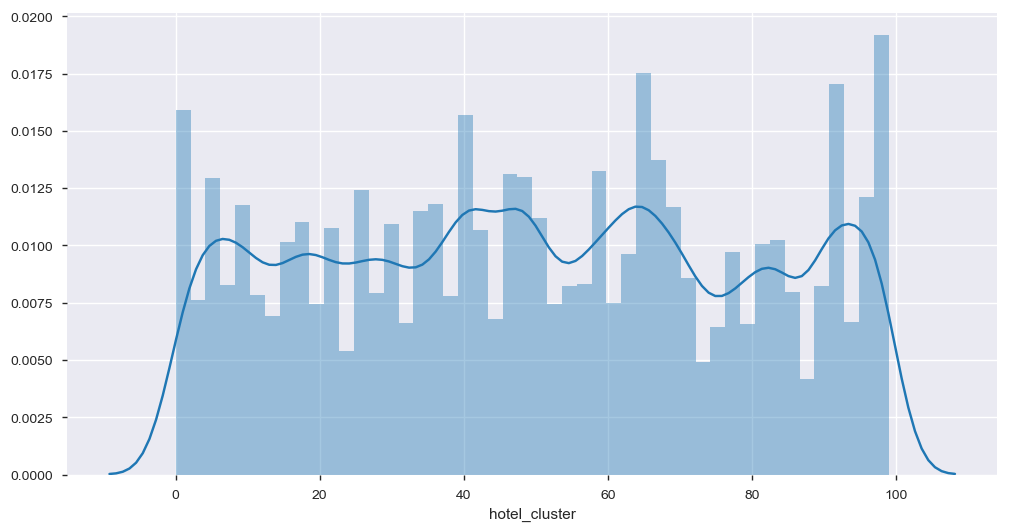

In [48]:
# histogram of clusters
plt.figure(figsize=(12, 6))
sns.distplot(train['hotel_cluster'])

The above histogram of hotel clusters tells us that the data is pretty much well distributed over all 100 clusters and there is skewness in the data.

### Feature Engineering

The following date columns can not be used directly in the model. Therefore I will extract year and month from them.

* **date_time** - Timestamp
* **srch_ci** - Checkin date
* **srch_co** - Checkout date

In [49]:
# get year part from a date

def get_year(x):
    '''
    Args:
        datetime
    Returns:
        year as numeric
    '''
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

# get month part from a date

def get_month(x):
    '''
    Args:
        datetime
    Returns:
        month as numeric
    '''    
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

# extract year and month from date time column
train['date_time_year'] = pd.Series(train.date_time, index = train.index)
train['date_time_month'] = pd.Series(train.date_time, index = train.index)

train.date_time_year = train.date_time_year.apply(lambda x: get_year(x))
train.date_time_month = train.date_time_month.apply(lambda x: get_month(x))
del train['date_time']

# extract year and month from check in date column
train['srch_ci_year'] = pd.Series(train.srch_ci, index = train.index)
train['srch_ci_month'] = pd.Series(train.srch_ci, index = train.index)

train.srch_ci_year = train.srch_ci_year.apply(lambda x: get_year(x))
train.srch_ci_month = train.srch_ci_month.apply(lambda x: get_month(x))
del train['srch_ci']

# extract year and month from check out date column
train['srch_co_year'] = pd.Series(train.srch_co, index = train.index)
train['srch_co_month'] = pd.Series(train.srch_co, index = train.index)

train.srch_co_year = train.srch_co_year.apply(lambda x: get_year(x))
train.srch_co_month = train.srch_co_month.apply(lambda x: get_month(x))
del train['srch_co']

# check the transformed data
train.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,8
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,9
2,2,3,66,348,48862,2234.2641,12,0,0,9,...,2,50,628,1,2014,8,2014,8,2014,9
3,2,3,66,442,35390,913.1932,93,0,0,3,...,2,50,1457,80,2014,8,2014,11,2014,11
4,2,3,66,442,35390,913.6259,93,0,0,3,...,2,50,1457,21,2014,8,2014,11,2014,11


### Priliminary Aaalysis

Let us visually look at the correlation of the entire dataset.

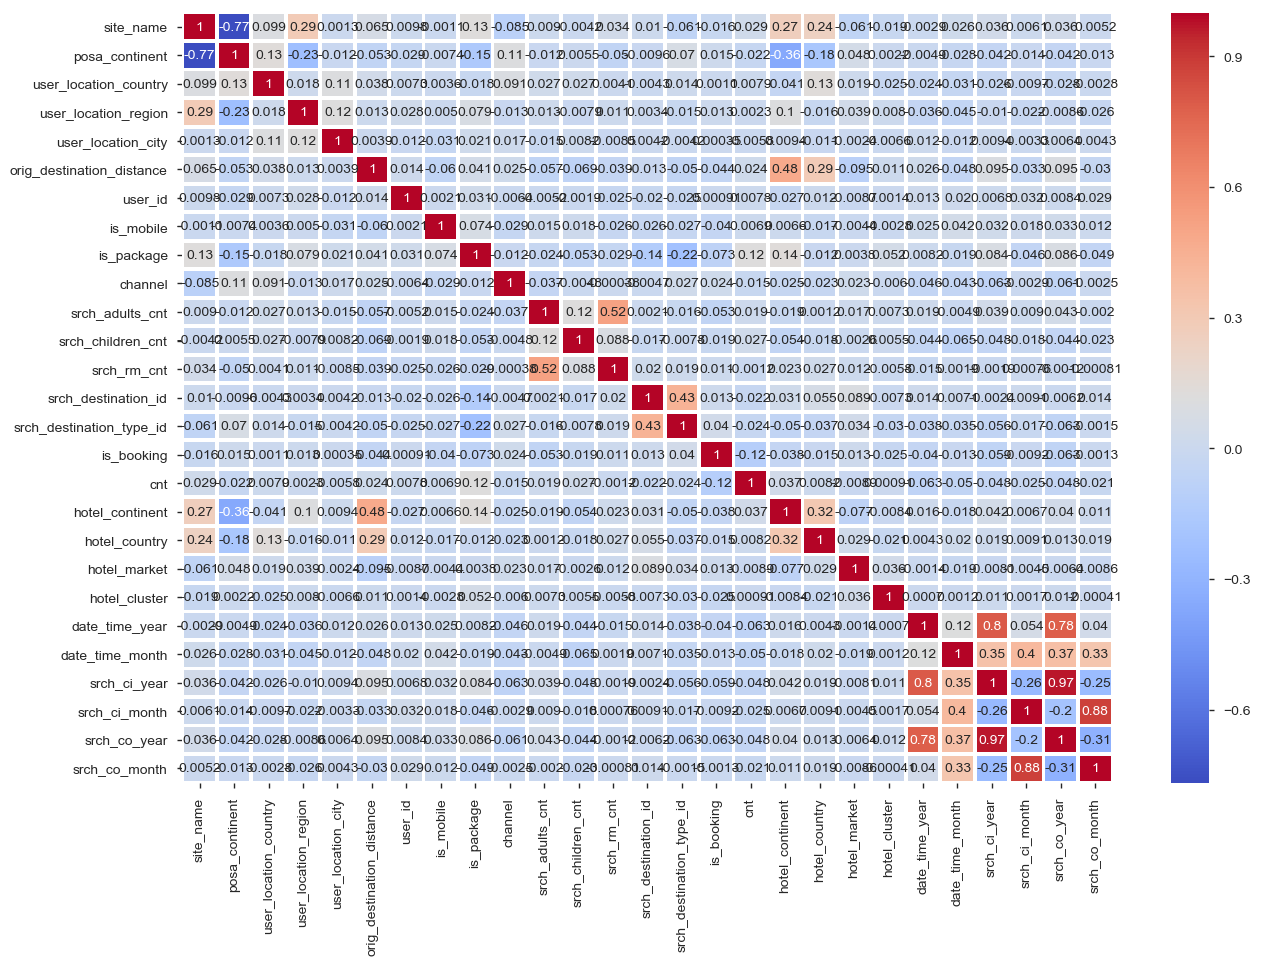

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(train.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

What we are most interested in, from this plot, is the relationship of other variables with hotel cluster. Let us take a closer look at that.

In [51]:
train.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.030064
is_booking                  -0.025380
user_location_country       -0.025170
hotel_country               -0.021170
site_name                   -0.019154
hotel_continent             -0.008441
srch_destination_id         -0.007258
user_location_city          -0.006580
channel                     -0.005956
srch_rm_cnt                 -0.005801
is_mobile                   -0.002803
srch_co_month               -0.000413
date_time_year               0.000696
cnt                          0.000914
date_time_month              0.001208
user_id                      0.001396
srch_ci_month                0.001682
posa_continent               0.002204
srch_children_cnt            0.005469
srch_adults_cnt              0.007322
user_location_region         0.008037
srch_ci_year                 0.010879
orig_destination_distance    0.011362
srch_co_year                 0.012014
hotel_market                 0.036107
is_package                   0.051955
hotel_cluste

There is no strong relationship or linear correlation between hotel_cluster and other variables, hence methods which model linear relationship between features might not be suitable for the problem.

From a common undertanding based on internet research, I am assuming that the following factors will be impactful when it comes to clustering.

**srch_destination_id** - ID of the destination where the hotel search was performed

**hotel_country** - Country where the hotel is located

**hotel_market** - Hotel market

**hotel_cluster** - ID of a hotel cluster

**is_package** - Whether part of a package or not (1/0)

**is_booking** - Booking (1) or Click (0)

Since we are only interested in booking events, let us get rid of clicks.

In [52]:
train_book = train.loc[train['is_booking'] == 1]

Create a pivot to map each cluster, and shape it accordingly so that it can be merged with the original data.

In [56]:
# step 1
factors = [train_book.groupby(['srch_destination_id','hotel_country','hotel_market','is_package','hotel_cluster'])['is_booking'].agg(['sum','count'])]
summ = pd.concat(factors).groupby(level=[0,1,2,3,4]).sum()
summ.dropna(inplace=True)
summ.head()

sum  \
srch_destination_id hotel_country hotel_market is_package hotel_cluster        
8                   50            416          0          32               1   
                                                          77               1   
11                  50            824          0          94               1   
14                  27            1434         0          20               1   
16                  50            419          0          7                1   

                                                                         count  
srch_destination_id hotel_country hotel_market is_package hotel_cluster         
8                   50            416          0          32                 1  
                                                          77                 1  
11                  50            824          0          94                 1  
14                  27            1434         0          20                 1  
16                  50            419          0          7                  1

In [57]:
# step 2
summ['sum_and_cnt'] = 0.85*summ['sum'] + 0.15*summ['count']
summ = summ.groupby(level=[0,1,2,3]).apply(lambda x: x.astype(float)/x.sum())
summ.reset_index(inplace=True)
summ.head()

,srch_destination_id,hotel_country,hotel_market,is_package,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,0,32,0.5,0.5,0.5
1,8,50,416,0,77,0.5,0.5,0.5
2,11,50,824,0,94,1.0,1.0,1.0
3,14,27,1434,0,20,1.0,1.0,1.0
4,16,50,419,0,7,1.0,1.0,1.0


In [58]:
# step 3
summ_pivot = summ.pivot_table(index=['srch_destination_id','hotel_country','hotel_market','is_package'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
summ_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,is_package,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,50,824,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,14,27,1434,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,50,419,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,77,1454,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Quickly check the destination data to determine the relationship with other data.

In [59]:
destination.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


Merge the filtered booking data, pivotted data and destination data to form a single wide dataset.

In [60]:
train_book = pd.merge(train_book, destination, how='left', on='srch_destination_id')
train_book = pd.merge(train_book, summ_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market','is_package'])
train_book.fillna(0, inplace=True)
train_book.shape

(8270, 276)

In [61]:
train_book.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,90,91,92,93,94,95,96,97,98,99
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,0.0,0.017857,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,2,3,66,318,52078,0.0000,756,0,1,4,...,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.071429,0.0
2,30,4,195,548,56440,0.0000,1048,0,1,9,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,30,4,195,991,47725,0.0000,1048,0,0,9,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,2,3,66,462,41898,2454.8588,1482,0,1,1,...,0.0,0.000000,0.0,0.0,0.0,0.750000,0.0,0.0,0.000000,0.0


### Algorithms

First, let us separate the target variable and predicter variables.

In [62]:
X = train_book.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = train_book.hotel_cluster
X.shape, y.shape

((8270, 273), (8270,))

Check if all of the 100 clusters are present in the training data.

In [63]:
y.nunique()

100

### 1. Support Vector Machine (SVM)

In [64]:
classifier = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.44068991421877335

### 2. Naive Bayes classifier

In [65]:
classifier = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.08713381802499252

### 3. Logistic Regression

In [66]:
classifier = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.3850620429664882

### 4. K-Nearest Neighbor classifier

In [69]:
classifier = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(classifier, X, y, cv=10, scoring='accuracy'))

0.38058519319445827

From the above algorithms, SVM perfoemed the best. Yet, the cross validation score is only 0.44. Other algorithms performed worse than that. Further feature engineering and increasing the number of folds might help improving the score.

The one pager summary for this approach is included in the notebook to keep the method coherent. 

## Summary

The algorithms were chosen based on the understanding of the data from the EDA and preliminary analysis. Here are the basis of the selection.

**1. SVM or Support Vector Machine**
SVM is capable of doing both classification and regression. Since we are trying to clasify users to hotel clusters, I have chosen SVM. As the clusters are multi level (100), this is using non-linear SVM. Non-linear SVM means that the boundary that the algorithm calculates doesn't have to be a straight line. The benefit is that we can capture much more complex relationships between the datapoints without having to perform difficult transformations on our own. The downside is that the training time is much longer as it's much more computationally intensive.

Using SVM, I have achieved the highest cross validation score.

**2. Naive Bayes classifier**
I wanted to try Naive Bayes algorithm because it is simple and if the conditional independence assumption actually holds, a it will converge quicker than discriminative models like logistic regression, hence it will need less training data. 

But it has the worst performance of the four models. Therefore, this classifier is not recommended for the problem at hand.

**3. Logistic Regression**
Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary).  In this case, we can think of the problem as, whether a hotel fall in a specific cluster (yes/no) based on the chosen features. 

Logistic Regression was close to the performance of SVM but slightly worse.

**4. K-Nearest Neighbor classifier**
KNN is a non-parametric, lazy learning algorithm. In the currentcontext, the idea is to teach the model which users (with other similar characteristics) chose which hotel cluster, and predict future cluster assignment based on that learning.

KNN performed very similar to Logistic Regression for the model in question.